# Reinforcement learning

Reinforcement learning komt uit de studie van Markov Chains of Processen voor.
Dit is een random opeenvolging van states waarbij elke transisitie een mogelijke kans heeft.
Door een reward te koppelen aan elke state waarin je komt kan je een functie opstellen die de de totale reward maximaliseert.
Dit is het basisidee achter reinforcement learning.

Een aantal belangrijke termen/concepten hierbij zijn:
* De agent
* Het environment
* De state space
* De action space
* De reward en return
* Exploration vs exploitation

## Q-learning

Een eerste algoritme dat we bekijken voor reinforcement learning uit te voeren is Q-learning.
Dit algoritme maakt gebruik van de Q-functie of action-value function.
Hiervoor houdt het Q-learning algoritme een matrix bij dat de reward van actie in een state bepaald.
In een verkenningsfase laten we toe dat er sub-optimale keuzes genomen worden.
Nadat dit lang genoeg gerund heeft, gaan we over naar een exploitation fase waarbij enkel de beste keuzes genomen worden.

Om te tonen hoe je het Q-learning algoritme kan implementeren, kan je gebruik maken van het gymnasium package.
Dit bevat heel wat eenvoudige environments van spelletjes in python die hiervoor gebruikt kunnen worden.
De bron voor onderstaande code komt van een [tutorial van de library](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)

In [10]:
!pip install gymnasium
!pip install gymnasium[classic-control]

In [11]:
%matplotlib inline

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym
from gymnasium.utils.play import play

env = gym.make("Blackjack-v1", sab=True, render_mode='rgb_array')


In [12]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()
print(observation, info)

(15, 4, 0) {}


Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)

In [13]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
next_state, reward, terminated, truncated, info = env.step(action)
print(observation)
print(reward)
print(terminated)   # geeft aan of het spel over is
print(truncated)    # ook gedaan als dit true is
print(info)


# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

(15, 4, 0)
-1.0
True
False
{}


In [14]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):            # in het begin grote epsilon -> neem veel random zetten, later kleinere epsilon zodat er vooral de beste zet genomen wordt
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [15]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [16]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:13<00:00, 7158.90it/s]


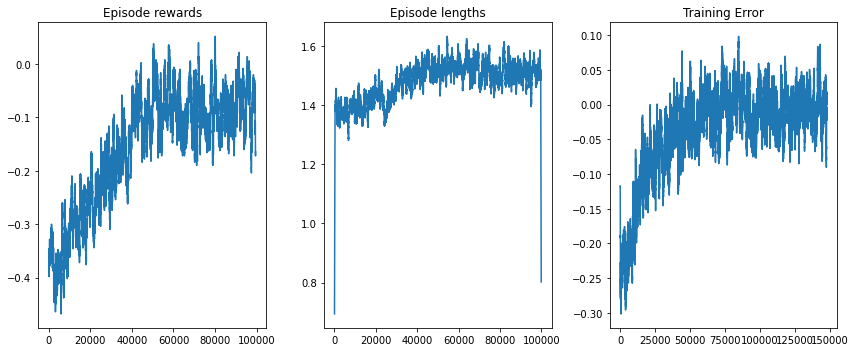

In [17]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

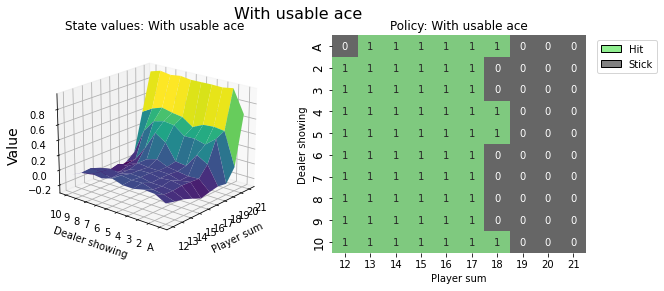

In [18]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

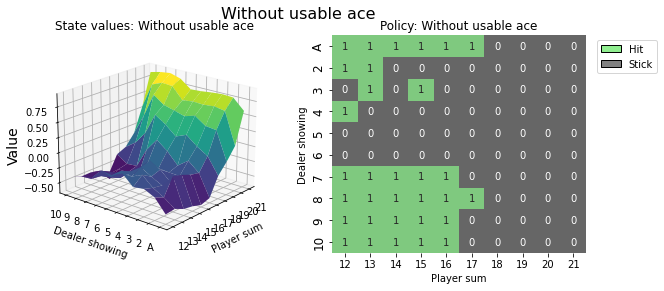

In [19]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [20]:
gym.utils.play.play(env, keys_to_action={"w":0, "s":1})

## RL in neural networks

Het gebruik van Q-learning werkt goed als het aantal states en acties beperkt zijn.
Dit is echter zelden het geval, denk bijvoorbeeld aan een continue variabele zoals snelheid of locatie.

Een oplossing hiervoor is om de action-value functie die in Q-learning geoptimaliseerd wordt te benaderen ipv exact te berekenen.
Dit kan bijvoorbeeld door middel van een neuraal netwerk te gebruiken.
Er zijn verschillende model-structuren die hiervoor ontwikkeld zijn zoals:
- DQN (onderwerp van onderstaande demo)
- REINFORCE
- DDPG
- TD3
- PPO
- SAC

Voor we beginnen met het uitwerken van een model.
Bekijk [deze tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) en beantwoord de volgende vragen:
- Wat is de state en wat zijn de mogelijke acties?
- Wat is de structuur van het gebruikte DQN?
- Zijn er nieuwe hyperparameters gebruikt?
- Welke metriek wordt er gebruikt en waar wordt deze berekend?
- Hoe worden de gewichten aangepast?
- Waarvoor wordt de ReplayBuffer gebruikt?

**Antwoord:**
- Vraag 1:
    - State: de positie en snelheid van het karretje en de hoek/hoeksnelheid van de staaf.
    - Acties: Beweeg naar links en beweeg naar rechts
- Vraag 2: Er zijn drie lagen met respectievelijk 100, 50 en 2 neuronen. Het is belangrijk dat het aantal neuronen in de laatste laag overeenkomt met het aantal acties.
- Vraag 3: De enige nieuwe hyperparameter bij het aanmaken van het neuraal netwerk is de initialiser. De hidden lagen gebruiken een VarianceScaler als kernel-initalisator wat inhoudt dat ze gesampled worden uit een Normaalverdeling. De outputlayer gebruikt een RandomUniform kernel-initializer (sample de gewichten uit een uniforme verdeling) en een constante waarde als bias-initializer
- Vraag 4: De average return wordt hiervoor gebruikt en deze wordt [hier](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial#metrics_and_evaluation) berekend. De return is de tijd dat de staaf omhoog blijft (1 voor elke tijdstap)
- Vraag 5 en 6: Je laadt het netwerk wat lopen, de uitgevoerde acties en bekomen rewards worden opgeslaan in de ReplayBuffer. Batches of data worden uit de replaybuffer gehaald om het netwerk te trainen op basis van de gemiddelde return

Schrijf nu zelf de nodige code om het DQN-model toe te passen op het "Mountain Car" environment van gymnasium.

In [25]:
import gymnasium as gym
from gymnasium.utils.play import play
env = gym.make('MountainCar-v0', render_mode="rgb_array")
play(env, keys_to_action={"a": 0, "s": 1, "d": 2})